# Import necessary libraries

In [1]:
import requests
from PIL import Image, ImageFilter
from io import BytesIO
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# Image downloading and Create dataset

In [ ]:
# Function to download a random image from the internet
def download_random_image():
    url = "https://picsum.photos/v2/list?limit=100"
    response = requests.get(url)
    images_data = response.json()
    random_image = images_data[random.randint(0, len(images_data) - 1)]
    image_url = random_image["download_url"]

    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            return Image.open(BytesIO(response.content))
        else:
            print(f"Failed to download image from {image_url}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None

In [ ]:
def blur_image(image, blur_type="gaussian", sigma=5):
    if blur_type == "gaussian":
        # Convert image to RGB if needed
        image = image.convert("RGB")
        return image.filter(ImageFilter.GaussianBlur(sigma))
    elif blur_type == "median":
        return image.filter(ImageFilter.MedianFilter(radius=3))  # Adjust radius as needed
    else:
        raise ValueError(f"Invalid blur type: {blur_type}")


In [ ]:
# Main download and processing loop
num_images = 100


In [ ]:
# Replace 'data' with your desired directory
high_res = "/content/drive/MyDrive/Colab Notebooks/raw_data/high_res"  # Adjust path as needed
low_res = "/content/drive/MyDrive/Colab Notebooks/raw_data/low_res"

for i in range(num_images):
    image = download_random_image()
    if image is None:
        continue  # Skip if download fails

    blurred_image = blur_image(image)

    # Save original image (adjust extension if needed)
    image.save(f"{high_res}/original_image_{i}.jpg", quality=90)

    # Save blurred image (adjust extension if needed)
    blurred_image.save(f"{low_res}/blurred_image_{i}.jpg", quality=90)

print("Download and processing complete!")

Download and processing complete!


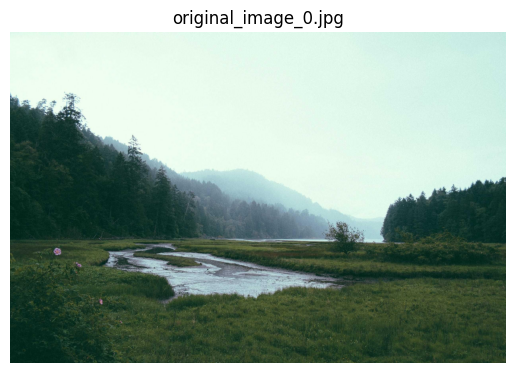

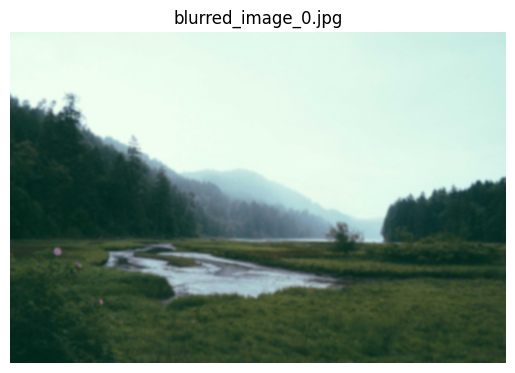

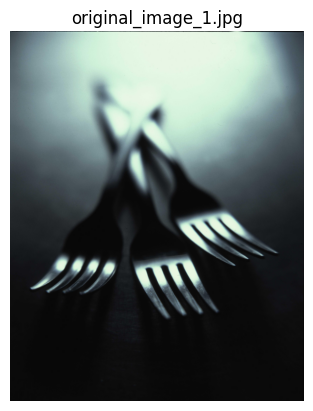

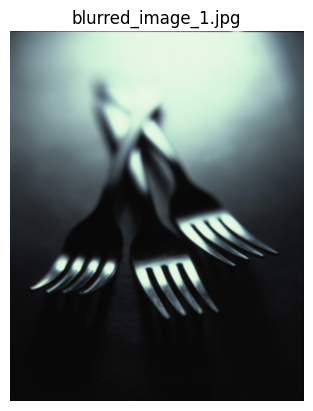

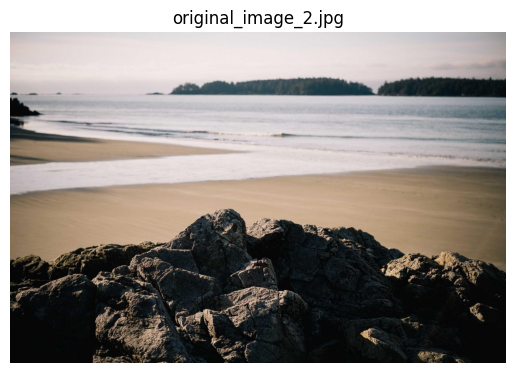

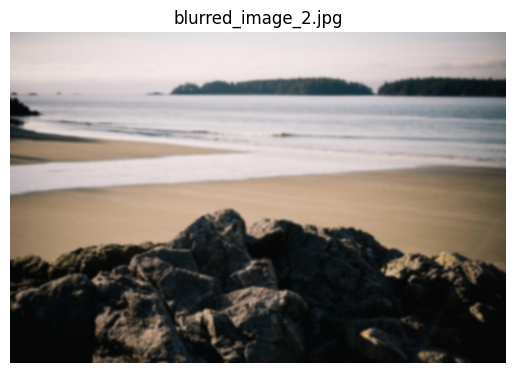

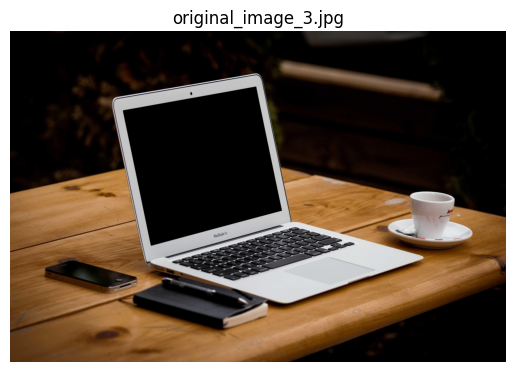

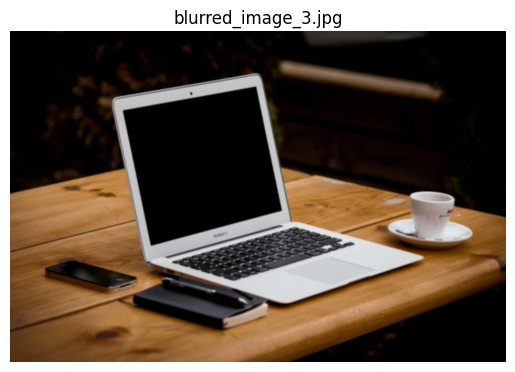

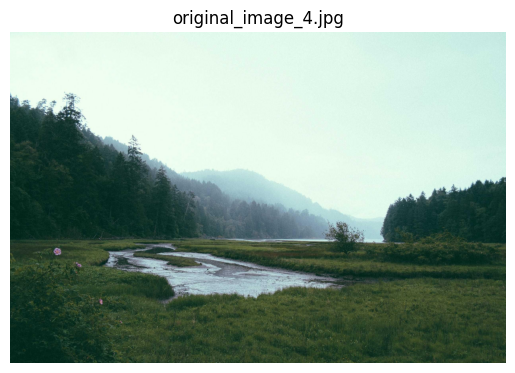

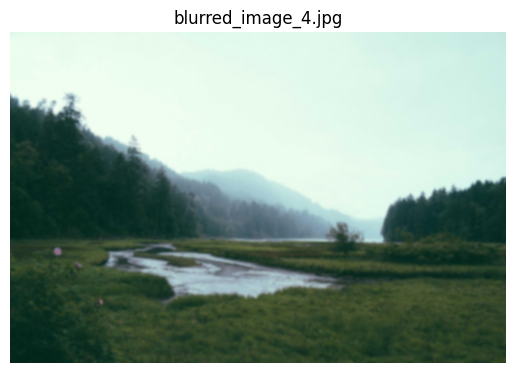

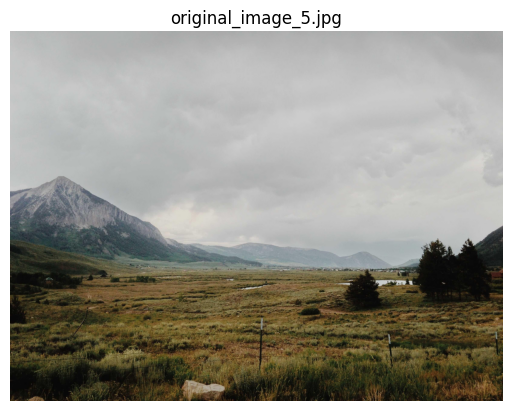

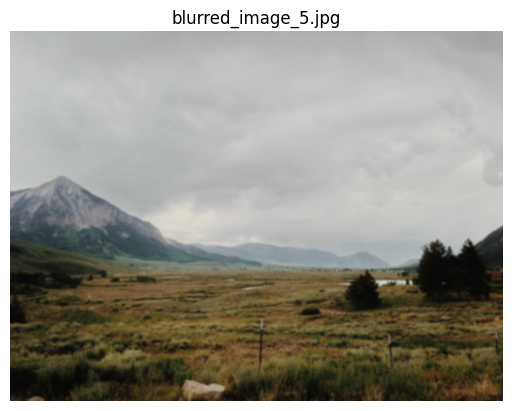

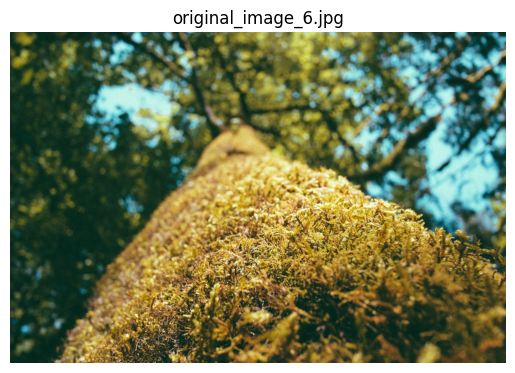

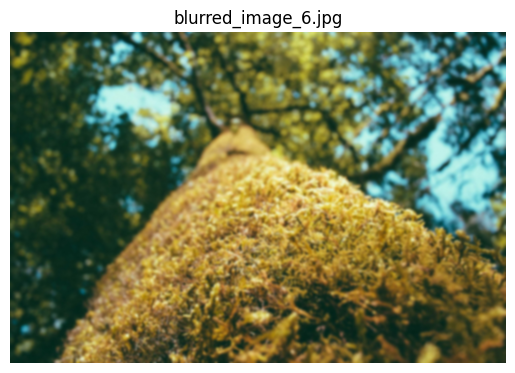

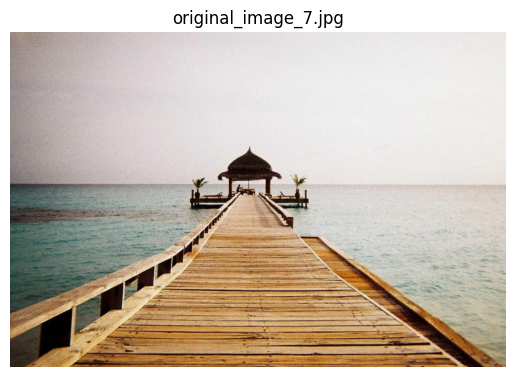

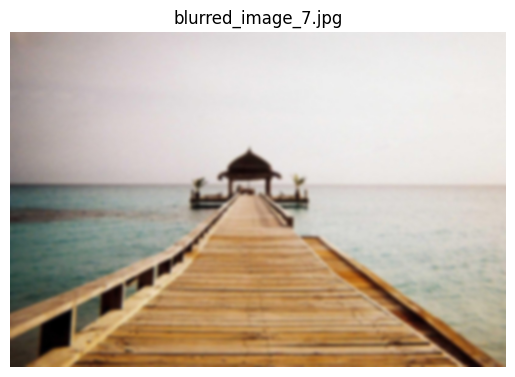

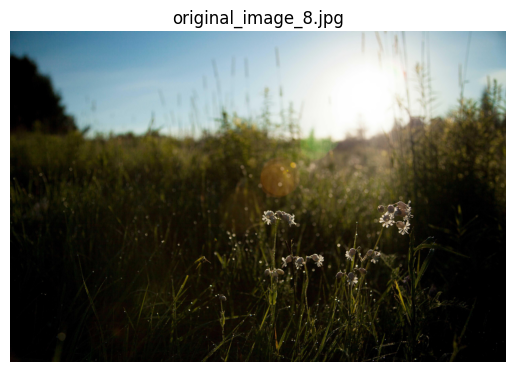

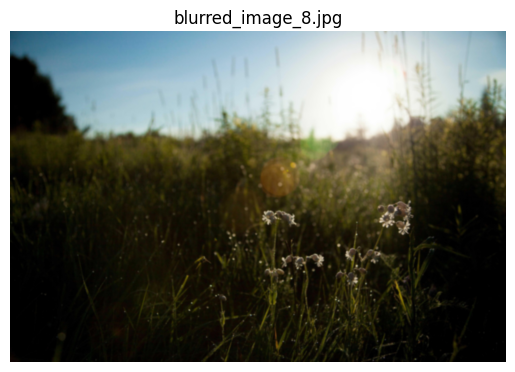

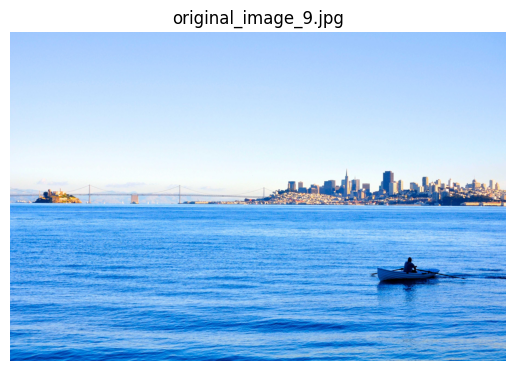

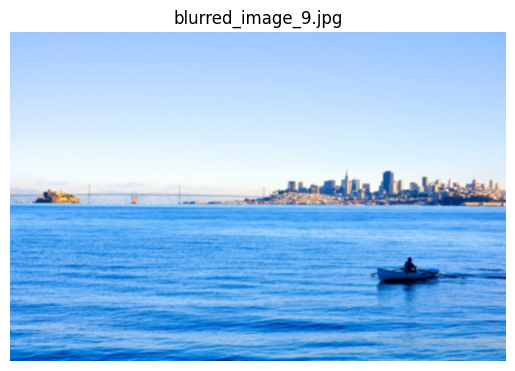

Plotting complete!


In [ ]:
# Function to plot an image from a file path
def plot_image(image_path):
    try:
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis("off")  # Hide axes for cleaner visualization
        plt.title(os.path.basename(image_path))  # Set title based on filename
        plt.show()
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")

num_images = 10  # Adjust the number of images to plot

for i in range(num_images):
    original_image_path = f"{high_res}/original_image_{i}.jpg"
    blurred_image_path = f"{low_res}/blurred_image_{i}.jpg"

    plot_image(original_image_path)
    plot_image(blurred_image_path)

print("Plotting complete!")


# Importing more librarys

In [2]:
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
# Define SRCNN model architecture
def build_srcnn_model():
    inputs = Input(shape=(None, None, 3))
    # First convolutional layer
    x = Conv2D(64, 9, activation='relu', padding='same')(inputs)
    # Second convolutional layer
    x = Conv2D(32, 1, activation='relu', padding='same')(x)
    # Third convolutional layer (reconstruction layer)
    outputs = Conv2D(3, 5, activation='linear', padding='same')(x)  # Output has 3 channels for RGB images
    model = Model(inputs, outputs)
    return model

In [4]:
path_to_low_res_images = '/content/drive/MyDrive/Colab Notebooks/raw_data/high_res'
path_to_high_res_images = '/content/drive/MyDrive/Colab Notebooks/raw_data/low_res'

In [5]:
import cv2
import os

In [6]:
def load_dataset(path, target_size=(128, 128)):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = cv2.resize(img, target_size)  # Resize image to target size
        images.append(img)
    return np.array(images)

In [11]:
# Load low-resolution images
low_res_images = load_dataset(path_to_low_res_images)

In [12]:
# Load high-resolution images
high_res_images = load_dataset(path_to_high_res_images)

In [13]:
# Split Data into Training, Validation, and Test Sets
X_train, X_test, y_train, y_test = train_test_split(low_res_images, high_res_images, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [14]:
# Define Loss Function and Metrics
loss_function = tf.keras.losses.MeanSquaredError()
metrics = ['accuracy']

In [15]:
# Training the SRCNN model
srcnn_model = build_srcnn_model()
srcnn_model.compile(optimizer='adam', loss=loss_function, metrics=metrics)
history = srcnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
3/3 [==============================] - 10s 2s/step - loss: 12882.2559 - accuracy: 0.5570 - val_loss: 3799.4871 - val_accuracy: 0.3728
Epoch 2/10
3/3 [==============================] - 10s 3s/step - loss: 3089.7297 - accuracy: 0.3283 - val_loss: 2562.1892 - val_accuracy: 0.2054
Epoch 3/10
3/3 [==============================] - 8s 2s/step - loss: 1664.6208 - accuracy: 0.2755 - val_loss: 1544.5072 - val_accuracy: 0.5951
Epoch 4/10
3/3 [==============================] - 10s 2s/step - loss: 1498.4783 - accuracy: 0.5148 - val_loss: 1488.6086 - val_accuracy: 0.6419
Epoch 5/10
3/3 [==============================] - 9s 3s/step - loss: 1350.5757 - accuracy: 0.5271 - val_loss: 1529.3275 - val_accuracy: 0.4587
Epoch 6/10
3/3 [==============================] - 8s 2s/step - loss: 1155.1951 - accuracy: 0.3538 - val_loss: 1615.2206 - val_accuracy: 0.2485
Epoch 7/10
3/3 [==============================] - 9s 3s/step - loss: 1090.3492 - accuracy: 0.2813 - val_loss: 1370.6808 - val_accuracy: 0.

In [16]:
# Evaluate SRCNN model performance
evaluation_results = srcnn_model.evaluate(X_test, y_test)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

1/1 [==============================] - 0s 381ms/step - loss: 898.4684 - accuracy: 0.2929
Test Loss: 898.4683837890625
Test Accuracy: 0.29287922382354736


In [17]:
# Fine-tuning and Optimization
model_fine_tuned = build_srcnn_model()
model_fine_tuned.compile(optimizer='adam', loss=loss_function, metrics=metrics)
history_fine_tuned = model_fine_tuned.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
3/3 [==============================] - 10s 3s/step - loss: 11783.0410 - accuracy: 0.3810 - val_loss: 3901.7073 - val_accuracy: 0.5285
Epoch 2/20
3/3 [==============================] - 8s 2s/step - loss: 3401.4832 - accuracy: 0.3267 - val_loss: 2227.4763 - val_accuracy: 0.2405
Epoch 3/20
3/3 [==============================] - 9s 3s/step - loss: 1852.3568 - accuracy: 0.3063 - val_loss: 1973.5093 - val_accuracy: 0.3225
Epoch 4/20
3/3 [==============================] - 8s 2s/step - loss: 1753.1497 - accuracy: 0.3457 - val_loss: 1839.3114 - val_accuracy: 0.4811
Epoch 5/20
3/3 [==============================] - 10s 3s/step - loss: 1670.9628 - accuracy: 0.4468 - val_loss: 1703.2007 - val_accuracy: 0.6027
Epoch 6/20
3/3 [==============================] - 7s 2s/step - loss: 1376.7534 - accuracy: 0.4174 - val_loss: 1938.9874 - val_accuracy: 0.3746
Epoch 7/20
3/3 [==============================] - 9s 2s/step - loss: 1443.4285 - accuracy: 0.3406 - val_loss: 1561.0210 - val_accuracy: 0.5

In [18]:
# Evaluate the fine-tuned model on the test dataset
evaluation_results = model_fine_tuned.evaluate(X_test, y_test)

# Print the evaluation results
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

1/1 [==============================] - 0s 403ms/step - loss: 572.3361 - accuracy: 0.5508
Test Loss: 572.3361206054688
Test Accuracy: 0.5507527589797974
